# Agent-Based Model Validation
A streamlined process for validating agent-based models:
1. Dataset Uniformity
2. Property Analysis  
3. Causal Structure Identification
4. Validation Assessment

In [1]:
import numpy as np
import pandas as pd
import os
import time

from src.run_causal_discovery import run_varlingam, run_pcmci, run_varlingam_bootstrap
from src.rcv_varlingam import run_rcv_varlingam
from src.rcv_pcmci import run_rcv_pcmci
from src.data_preprocessing import preprocess_data
from src.dataset_properties import analyze_rw_properties, analyze_ab_properties
from src.causal_matrix_evaluation import evaluate_causal_matrices
from src.plotting import plot_heatmap, plot_causal_graph

## Step 1: Dataset Preprocessing and Uniformity
Preprocess and align RW and ABM datasets. This step ensures data consistency by handling missing values, applying transformations, and aligning time series lengths.

In [2]:
def uniform_datasets(RW_data, AB_data, columns, log_vars=None, percent_vars=None, inf_nan_method='interpolate'):
    # Assume RW_data and AB_data are numpy arrays
    RW_processed = preprocess_data(RW_data, columns, log_vars, percent_vars, inf_nan_method)
    
    # For AB_data, we need to process each simulation
    AB_processed = np.array([preprocess_data(sim, columns, log_vars, percent_vars, inf_nan_method) 
                             for sim in AB_data])
    
    # Ensure both datasets have the same time length
    min_time = min(RW_processed.shape[0], AB_processed.shape[1])
    RW_processed = RW_processed[-min_time:]
    AB_processed = AB_processed[:, -min_time:, :]

    return RW_processed, AB_processed

## Step 2: Analysis of Dataset Properties
Analyze statistical properties of datasets, including linearity, stationarity, statistical equilibrium, and ergodicity. This provides insights into the fundamental characteristics of both RW and ABM data.

In [3]:
def analyze_and_print_properties(RW_data, AB_data, columns):
    rw_properties = analyze_rw_properties(RW_data)
    ab_properties = analyze_ab_properties(AB_data)
    
    print("Dataset Properties Analysis:")
    print("----------------------------")
    for i, col in enumerate(columns):
        print(f"{col}:")
        print(f"  RW Linearity: {rw_properties['linearity'][i]:.3f}")
        print(f"  RW Stationarity: {rw_properties['stationarity'][i]:.3f}")
        print(f"  AB Linearity: {ab_properties['linearity'][i]:.3f}")
        print(f"  AB Stationarity: {ab_properties['stationarity'][i]:.3f}")
        print(f"  AB Statistical Equilibrium: {ab_properties['statistical_equilibrium'][i]:.3f}")
        print(f"  AB Ergodicity: {ab_properties['ergodicity'][i]:.3f}")
        print()

## Step 3: Causal Structure Identification
Identify causal structures using selected methods such as VAR-LiNGAM or PCMCI and the RCV-extended versions. This step reveals the underlying causal relationships in both RW and ABM data.

In [4]:
def run_causal_discovery(data, method='varlingam', columns=None):
    # Choose from varlingam, pcmci, rcv_varlingam, rcv_pcmci, varlingam_bootstrap
    if method == 'varlingam':
        result = run_varlingam(data)
        adjacency_matrices = result.adjacency_matrices_
    elif method == 'pcmci':
        adjacency_matrices = run_pcmci(data)
    elif method == 'rcv_varlingam':
        adjacency_matrices = run_rcv_varlingam(data)
    elif method == 'rcv_pcmci':
        adjacency_matrices = run_rcv_pcmci(data)
    elif method == 'varlingam_bootstrap':
        adjacency_matrices = run_varlingam_bootstrap(data)
    else:
        raise ValueError(f"Invalid causal discovery method: {method}")
    
    return adjacency_matrices

## Step 4: Validation Assessment
Compare and evaluate causal structures between RW and ABM data. This includes metrics like Structural Hamming Distance, F1 scores, and similarity measures to quantify the alignment between the two models.

In [5]:
def validate_causal_structures(RW_structure, AB_structure):
    # Ensure both structures have the same number of lags
    max_lags = max(len(RW_structure), len(AB_structure))
    RW_padded = pad_structure(RW_structure, max_lags)
    AB_padded = pad_structure(AB_structure, max_lags)
    
    # Get the evaluation results of SHD, F1 score, F1_directed and Frobenius norm
    evaluation = evaluate_causal_matrices(RW_padded, AB_padded)
    
    # Calculate similarity
    sign_similarity = np.mean(np.sign(RW_padded) == np.sign(AB_padded))
    size_similarity = np.mean(
        (AB_padded >= RW_padded - 2*np.std(RW_padded)) & 
        (AB_padded <= RW_padded + 2*np.std(RW_padded))
    )
    conj_similarity = np.mean(
        (np.sign(RW_padded) == np.sign(AB_padded)) & 
        (AB_padded >= RW_padded - 2*np.std(RW_padded)) & 
        (AB_padded <= RW_padded + 2*np.std(RW_padded))
    )
    
    return {
        'shd': evaluation['shd'],
        'f1_score': evaluation['f1'],
        'f1_score_directed': evaluation['f1_directed'],
        'frobenius_norm': evaluation['fro'],
        'sign_similarity': sign_similarity,
        'size_similarity': size_similarity,
        'conjugate_similarity': conj_similarity
    }

def pad_structure(structure, target_lags):
    """Pad the structure with zeros to reach the target number of lags"""
    if len(structure) >= target_lags:
        return structure[:target_lags]
    else:
        padding = [np.zeros_like(structure[0]) for _ in range(target_lags - len(structure))]
        return np.vstack((structure, padding))

## Running the Code
We run the validation process on the given ABM and RW-data.


Average Validation Results:
shd: 26.667 ± 4.796
f1_score: 0.492 ± 0.056
f1_score_directed: 0.488 ± 0.064
frobenius_norm: 0.649 ± 0.144
sign_similarity: 0.720 ± 0.026
size_similarity: 0.998 ± 0.007
conjugate_similarity: 0.720 ± 0.026
Total Runtime: 1.089 seconds


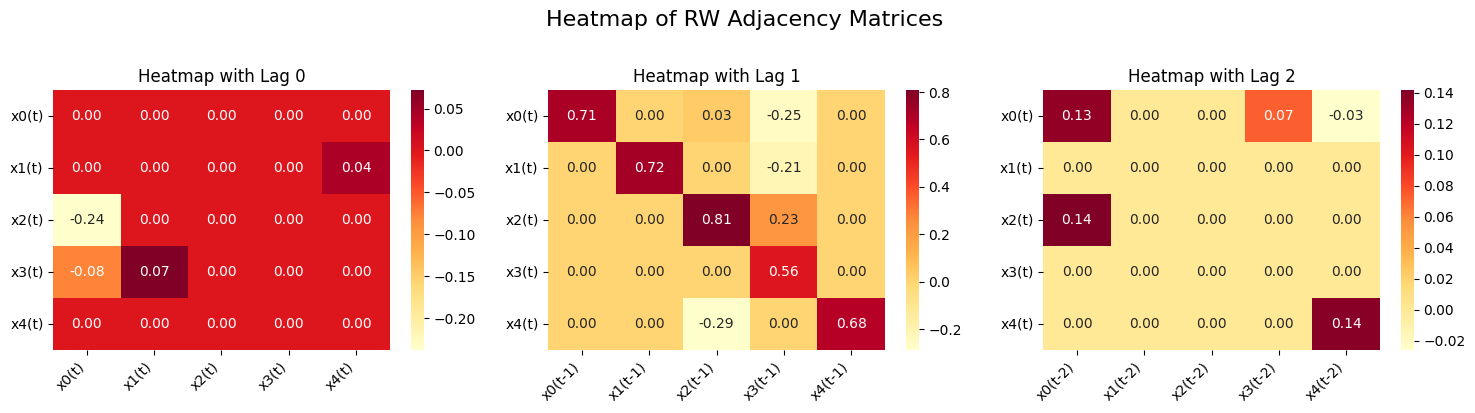

<Figure size 640x480 with 0 Axes>

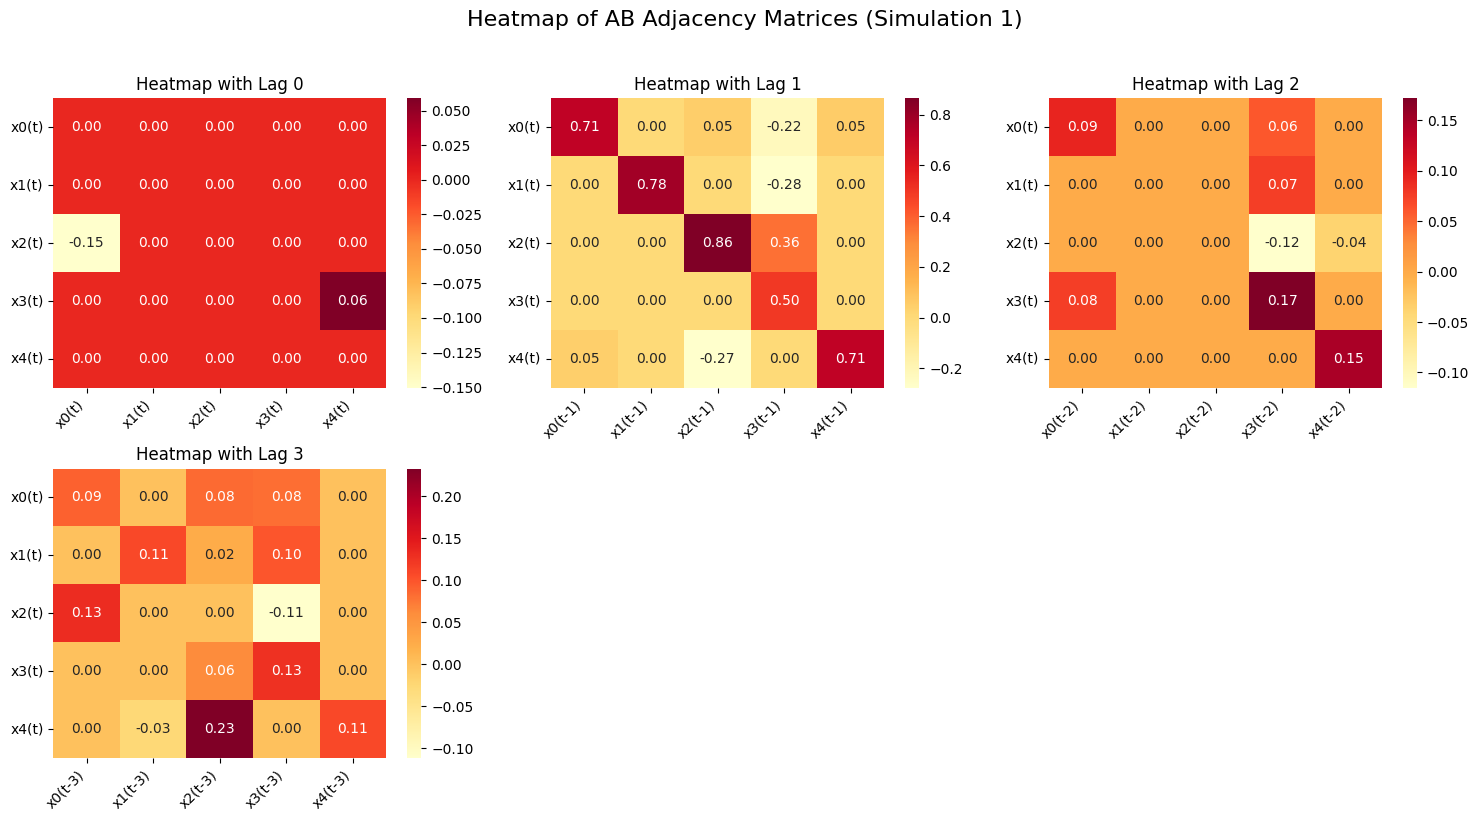

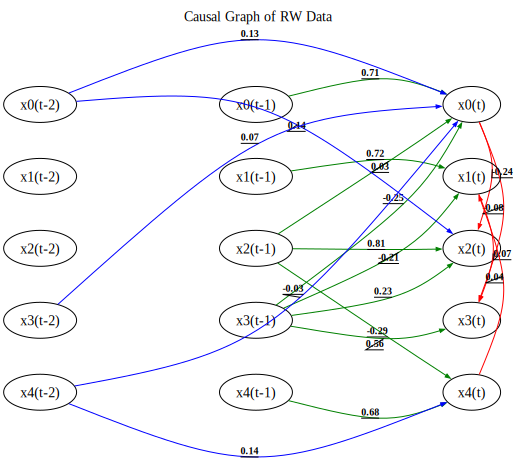

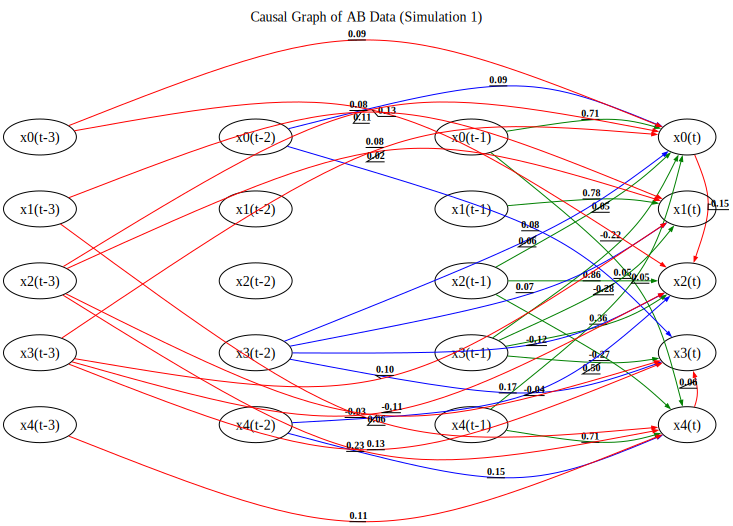

<Figure size 640x480 with 0 Axes>

In [6]:
def run_abm_validation(rw_data_path, ab_data_path, output_dir, 
                       log_vars=None, percent_vars=None, 
                       inf_nan_method='interpolate', causal_method='varlingam'):
    # Load RW data
    rw_data = pd.read_csv(rw_data_path)
    columns = rw_data.columns.tolist()
    if "Date" in columns:
        rw_data = rw_data.drop(['Date'], axis=1)
        columns.remove('Date')
    elif "timestamp" in columns:
        rw_data = rw_data.drop(['timestamp'], axis=1)
        columns.remove('timestamp')
    RW_data = rw_data.values

    # Load AB data
    AB_data = []
    for i in range(9):  # Assuming 9 AB data files (0-8)
        ab_file_path = f'{ab_data_path}{i}.csv'
        if os.path.exists(ab_file_path):
            ab_data = pd.read_csv(ab_file_path)
            if "Date" in ab_data.columns:
                ab_data = ab_data.drop(['Date'], axis=1)
            elif "timestamp" in ab_data.columns:
                ab_data = ab_data.drop(['timestamp'], axis=1)
            AB_data.append(ab_data.values)
    AB_data = np.array(AB_data)

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f'validation_results_{causal_method}.csv')
    
    
    # Step 1: Dataset Preprocessing and Uniformity
    start_time = time.time()
    RW_processed, AB_processed = uniform_datasets(RW_data, AB_data, columns, log_vars, percent_vars, inf_nan_method)
    
    # Step 2: Dataset Property Analysis
    # analyze_and_print_properties(RW_processed, AB_processed, columns)
    
    # Step 3: Causal Structure Identification
    RW_adjacency_matrices = run_causal_discovery(RW_processed, method=causal_method, columns=columns)
    AB_adjacency_matrices = [run_causal_discovery(sim, method=causal_method, columns=columns) for sim in AB_processed]
    
    # Step 4: Validation Assessment
    validation_results = []
    for i, AB_adj in enumerate(AB_adjacency_matrices):
        result = validate_causal_structures(RW_adjacency_matrices, AB_adj)
        validation_results.append(result)
    
    total_runtime = time.time() - start_time
    
    # Convert results to DataFrame
    df_results = pd.DataFrame(validation_results)
    
    # Calculate average and standard deviation
    avg_results = df_results.mean()
    std_results = df_results.std()
    
    # Save results to file
    with open(output_file, 'w') as f:
        f.write("Individual Simulation Results:\n")
        df_results.to_csv(f, index_label='Simulation')
        f.write("\nAverage Results:\n")
        avg_results.to_csv(f, header=True)
        f.write("\nStandard Deviation of Results:\n")
        std_results.to_csv(f, header=True)
        f.write("\nTotal Runtime:\n" + str(total_runtime))
    
    # Print average results to screen
    print("\nAverage Validation Results:")
    for key, value in avg_results.items():
        print(f"{key}: {value:.3f} ± {std_results[key]:.3f}")
    print(f"Total Runtime: {total_runtime:.3f} seconds")
    
    # Plotting
    plot_heatmap(RW_adjacency_matrices, columns, title="Heatmap of RW Adjacency Matrices")
    plot_heatmap(AB_adjacency_matrices[0], columns, title="Heatmap of AB Adjacency Matrices (Simulation 1)")
    
    causal_graph = plot_causal_graph(RW_adjacency_matrices, columns, title="Causal Graph of RW Data")
    # causal_graph.render('causal_graph', format='pdf')
    display(causal_graph)
    
    causal_graph = plot_causal_graph(AB_adjacency_matrices[0], columns, title="Causal Graph of AB Data (Simulation 1)")
    display(causal_graph)

# Example usage
rw_data_path = 'data/testing_ABM/RW_data.csv'
ab_data_path = 'data/testing_ABM/ABM_data'
output_dir = 'results/testing_ABM/'

# Choose from varlingam, pcmci, rcv_varlingam, rcv_pcmci, varlingam_bootstrap
run_abm_validation(rw_data_path, ab_data_path, output_dir, causal_method='varlingam')